In [13]:
#########################################################################################
# AdEx & HH Network                                                                     #
# 1.Use numpy only to build the network                                                 #
# 2.Set the path for the verilog                                                        #
#########################################################################################
# (1)N1 200 FS G1 Qi # 0.25*200: HH, 0.75*200: AdEx                                     #
# (2)N2 800 RS G2 Qe # 0.25*800: HH, 0.75*800: AdEx                                     #
# (3)P2 800 RS G2 Qe # 800: AdEx                                                        #
#########################################################################################
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import datetime

In [14]:
#########################################################################################
# units and constants                                                                   #
# Unified as a standard unit                                                            #
#########################################################################################

# 总的神经元数量
Num=1000
# 输入的最大幅值
AmpStim=80 # 80,92
# 输入的持续时间
plat = 1000
# 输入的噪声强度
TauP=100
# 静息时的输入强度
rest=8
# AdEx突触的传递时间
tau_S_AdEx=2
# AdEx耐火时间，不应期
T_ref_AdEx=10
# HH突触的传递时间
tau_S_HH=6
# HH耐火时间，不应期
T_ref_HH=10

ms=1e-3
mV=1e-3
mA=1e-3
nA=1e-9
pA=1e-12
nS=1e-9
pF=1e-12

# whole world time
tick_time=0
# minium gap time3
dt=0.1*ms
# total time
TotTime=4000*ms
# time of fire
fire1_num=0
fire2_num=0
time_sim=np.arange(0, TotTime, dt)
# average data analysis
bin_num=1000
N1=int(Num*0.2)
N2=int(Num*0.8)
N1_A=int(N1*0.75)
N1_H=int(N1*0.25)
N2_A=int(N2*0.75)
N2_H=int(N2*0.25)
N_in=int(N2)
# create neurons
A1_Group=[]
A2_Group=[]
H1_Group=[]
H2_Group=[]
G_Group=[]
P2_Group=[]
# something to record
fire1_result=[]
fire2_result=[]
fire1_result_bin=[]
fire2_result_bin=[]
neuron1_potential_bin = []
neuron2_potential_bin = []
test_input_index=0
global fire_matrix1, fire_matrix2
fire_matrix1=np.zeros((N1, len(time_sim)))
fire_matrix2=np.zeros((N2, len(time_sim)))

def bin_data(data):
    try:    
        return np.mean(data[len(data)-bin_num:len(data)])
    except:
        return data[len(data)-1]

def extract_number_from_string(s):
    match = re.search(r'_(\d+)$', s)
    if match:
        return int(match.group(1))
    else:
        return None

In [15]:
#########################################################################################    
# AdEx neuron model                                                                     #
# define its characteristic parameter                                                   #
#########################################################################################

class AdExNeuron:
    def __init__(self, name, position, V_Neuron, w_adaptive, G_Synapsis_Excitatory, G_Synapsis_Inhibitory, 
                 E_Excitatory, E_Inhibitory, E_local, G_local, V_disturb, V_Excitatory_Threshold,C_Membrane, 
                 a_w_adaptive, tau_w_adaptive,
                 tau_Synapsis,
                 V_Reset_Threshold, V_Reset, b_w_adaptive,
                 I_Synapsis, T_refractory, T_rest,
                 Connecting_Neuron, Q_Synapsis, Probability_Connecting):
        # variable parameters
        self.name = name
        self.V_Neuron = V_Neuron
        self.position = position
        self.w_adaptive = w_adaptive
        self.G_Synapsis_Excitatory = G_Synapsis_Excitatory
        self.G_Synapsis_Inhibitory = G_Synapsis_Inhibitory
        # fixed parameters
        self.E_Excitatory = E_Excitatory
        self.E_Inhibitory = E_Inhibitory
        self.E_local = E_local
        self.G_local = G_local
        self.V_disturb = V_disturb
        self.V_Excitatory_Threshold = V_Excitatory_Threshold
        self.C_Membrane = C_Membrane
        self.T_refractory = T_refractory
        # adaptive parameters
        self.a_w_adaptive = a_w_adaptive
        self.tau_w_adaptive = tau_w_adaptive
        self.tau_Synapsis = tau_Synapsis
        # reset parameters
        self.V_Reset_Threshold = V_Reset_Threshold
        self.V_Reset = V_Reset
        self.b_w_adaptive = b_w_adaptive
        self.I_Synapsis = I_Synapsis
        self.T_rest = T_rest
        # connecting neurons
        self.Connecting_Neuron = Connecting_Neuron
        self.Q_Synapsis = Q_Synapsis
        self.Probability_Connecting = Probability_Connecting
    def refresh_w_adaptive(self):
        # if self.T_rest<=0:
            self.w_adaptive = self.w_adaptive+dt*(self.a_w_adaptive*(self.V_Neuron-self.E_local)-self.w_adaptive)/self.tau_w_adaptive
    def refresh_G_Synapsis_Excitatory(self):
        # if self.T_rest<=0:
            self.G_Synapsis_Excitatory = self.G_Synapsis_Excitatory-dt*self.G_Synapsis_Excitatory/self.tau_Synapsis
    def refresh_G_Synapsis_Inhibitory(self):
        # if self.T_rest<=0:
            self.G_Synapsis_Inhibitory = self.G_Synapsis_Inhibitory-dt*self.G_Synapsis_Inhibitory/self.tau_Synapsis
    def refresh_membrane_potential(self):
        if self.T_rest<=0:
            self.V_Neuron =self.V_Neuron+dt*(self.G_Synapsis_Excitatory*(self.E_Excitatory-self.V_Neuron)+
                                        self.G_Synapsis_Inhibitory*(self.E_Inhibitory-self.V_Neuron)+
                                        self.G_local*(self.E_local-self.V_Neuron)+
                                        self.G_local*self.V_disturb*np.exp((self.V_Neuron-self.V_Excitatory_Threshold)/self.V_disturb)-
                                        self.w_adaptive+self.I_Synapsis
                                        )/self.C_Membrane
        else:
            self.T_rest=self.T_rest-dt
        self.refresh_w_adaptive()
        self.refresh_G_Synapsis_Excitatory()
        self.refresh_G_Synapsis_Inhibitory()
    def fire(self, num1, num2):
        global fire_matrix
        # refresh self parameter
        self.V_Neuron = self.V_Reset
        self.w_adaptive = self.w_adaptive+self.b_w_adaptive
        self.T_rest=self.T_refractory
        # refresh the G_Synapsis
        # print(self.name)
        if self.name[1]=='1':
            num1=num1+1
            fire_matrix1[extract_number_from_string(self.name)-1,test_input_index]=2
            for neuron1 in self.Connecting_Neuron:
                neuron1.G_Synapsis_Inhibitory=neuron1.G_Synapsis_Inhibitory+self.Q_Synapsis
        if self.name[1]=='2':
            num2=num2+1
            fire_matrix2[extract_number_from_string(self.name)-1,test_input_index]=2
            for neuron2 in self.Connecting_Neuron:
                neuron2.G_Synapsis_Excitatory=neuron2.G_Synapsis_Excitatory+self.Q_Synapsis
        return num1, num2
    def judge_fire(self, num1, num2):
        if self.V_Neuron>self.V_Reset_Threshold:
            num1, num2=self.fire(num1, num2)
        else:
            pass
        return num1, num2
    def Add_Synapsis(self, Synapsis):
        self.Connecting_Neuron.append(Synapsis)

# Initialize the FS and RS neuron
# All the parameters are got from the paper
AdEx_FS_neuron=AdExNeuron(name="Ex_A1_1",V_Neuron=-65*mV, position=(0,0), w_adaptive=0.0*pA, G_Synapsis_Excitatory=0.0*nS, G_Synapsis_Inhibitory=0.0*nS,
                                E_Excitatory=0.0*mV, E_Inhibitory=-80*mV, E_local=-65*mV, G_local=10*nS, V_disturb=0.5*mV, V_Excitatory_Threshold=-48*mV, C_Membrane=200*pF,
                                a_w_adaptive=0.0*nS, tau_w_adaptive=1.0*ms,
                                tau_Synapsis=tau_S_AdEx*ms,
                                V_Reset_Threshold=-47.5*mV, V_Reset=-65*mV, b_w_adaptive=0.0*pA,
                                I_Synapsis=0.0*pA, T_refractory=T_ref_AdEx*ms, T_rest=0*ms,
                                Connecting_Neuron=[], Q_Synapsis=5.0*nS, Probability_Connecting=0.05)
AdEx_RS_neuron=AdExNeuron(name="Ex_A2_1",V_Neuron=-65*mV, position=(0,0), w_adaptive=0.0*pA, G_Synapsis_Excitatory=0.0*nS, G_Synapsis_Inhibitory=0.0*nS,
                                E_Excitatory=0.0*mV, E_Inhibitory=-80*mV, E_local=-65*mV, G_local=10*nS, V_disturb=2*mV, V_Excitatory_Threshold=-50*mV, C_Membrane=200*pF,
                                a_w_adaptive=0.0*nS, tau_w_adaptive=1000.0*ms,
                                tau_Synapsis=tau_S_AdEx*ms,
                                V_Reset_Threshold=-47.5*mV, V_Reset=-65*mV, b_w_adaptive=0.0*pA,
                                I_Synapsis=0.0*pA, T_refractory=T_ref_AdEx*ms, T_rest=0*ms,
                                Connecting_Neuron=[], Q_Synapsis=1.5*nS, Probability_Connecting=0.05)


In [16]:
class HHNeuron:
    def __init__(self, name, position, V_Neuron, G_Synapsis_Excitatory, G_Synapsis_Inhibitory, 
                 E_Excitatory, E_Inhibitory, E_local, G_local, V_Excitatory_Threshold,C_Membrane, 
                 tau_Synapsis,
                 V_Reset_Threshold, V_Reset,
                 I_Synapsis, T_refractory, T_rest,
                 Connecting_Neuron, Q_Synapsis, Probability_Connecting,
                 G_Synapsis_K, G_Synapsis_Na, E_K, E_Na,
                 n_coefficient, m_coefficient, h_coefficient):
        # variable parameters
        self.name = name
        self.V_Neuron = V_Neuron
        self.position = position
        self.G_Synapsis_Excitatory = G_Synapsis_Excitatory
        self.G_Synapsis_Inhibitory = G_Synapsis_Inhibitory
        # fixed parameters
        self.E_Excitatory = E_Excitatory
        self.E_Inhibitory = E_Inhibitory
        self.E_local = E_local
        self.G_local = G_local
        self.V_Excitatory_Threshold = V_Excitatory_Threshold
        self.C_Membrane = C_Membrane
        self.T_refractory = T_refractory
        # adaptive parameters
        self.tau_Synapsis = tau_Synapsis
        # reset parameters
        self.V_Reset_Threshold = V_Reset_Threshold
        self.V_Reset = V_Reset
        self.I_Synapsis = I_Synapsis
        self.T_rest = T_rest
        # connecting neurons
        self.Connecting_Neuron = Connecting_Neuron
        self.Q_Synapsis = Q_Synapsis
        self.Probability_Connecting = Probability_Connecting
        # HH model parameters
        self.G_Synapsis_K = G_Synapsis_K
        self.G_Synapsis_Na = G_Synapsis_Na
        self.E_K = E_K
        self.E_Na = E_Na
        self.n_coefficient = n_coefficient
        self.m_coefficient = m_coefficient
        self.h_coefficient = h_coefficient
    def refresh_G_Synapsis_Excitatory(self):
        self.G_Synapsis_Excitatory = self.G_Synapsis_Excitatory-dt*self.G_Synapsis_Excitatory/self.tau_Synapsis
    def refresh_G_Synapsis_Inhibitory(self):
        self.G_Synapsis_Inhibitory = self.G_Synapsis_Inhibitory-dt*self.G_Synapsis_Inhibitory/self.tau_Synapsis
    def refresh_n_coefficient(self):
        self.n_coefficient = self.n_coefficient+dt*(0.032/mV*(15*mV-self.V_Neuron+self.V_Excitatory_Threshold)/(np.exp((15*mV-self.V_Neuron+self.V_Excitatory_Threshold)/5/mV)-1)*(1-self.n_coefficient)/ms
                                                        -0.5*np.exp((10*mV-self.V_Neuron+self.V_Excitatory_Threshold)/40/mV)*self.n_coefficient/ms)
    def refresh_h_coefficient(self):
        self.h_coefficient = self.h_coefficient+dt*(0.128*np.exp((17*mV-self.V_Neuron+self.V_Excitatory_Threshold)/18/mV)*(1-self.h_coefficient)/ms
                                                        -4/(1+np.exp((40*mV-self.V_Neuron+self.V_Excitatory_Threshold)/5/mV))*self.h_coefficient/ms)
    def refresh_m_coefficient(self):
        self.m_coefficient = self.m_coefficient+dt*(0.32/mV*(13*mV-self.V_Neuron+self.V_Excitatory_Threshold)/(np.exp((13*mV-self.V_Neuron+self.V_Excitatory_Threshold)/4/mV)-1)*(1-self.m_coefficient)/ms
                                                        -0.28/mV*(self.V_Neuron-self.V_Excitatory_Threshold-40*mV)/(np.exp((self.V_Neuron-self.V_Excitatory_Threshold-40*mV)/5/mV)-1)*self.m_coefficient/ms)
    def refresh_membrane_potential(self):
        if self.T_rest<=0:
            self.V_Neuron =self.V_Neuron+dt*(self.G_Synapsis_Excitatory*(self.E_Excitatory-self.V_Neuron)+
                                        self.G_Synapsis_Inhibitory*(self.E_Inhibitory-self.V_Neuron)+
                                        self.G_local*(self.E_local-self.V_Neuron)+
                                        self.G_Synapsis_K*self.n_coefficient*self.n_coefficient*self.n_coefficient*self.n_coefficient*(self.E_K-self.V_Neuron)+
                                        self.G_Synapsis_Na*self.m_coefficient*self.m_coefficient*self.m_coefficient*self.h_coefficient*(self.E_Na-self.V_Neuron)+
                                        self.I_Synapsis
                                        )/self.C_Membrane
        else:
            self.T_rest=self.T_rest-dt
        self.refresh_G_Synapsis_Excitatory()
        self.refresh_G_Synapsis_Inhibitory()
        self.refresh_n_coefficient()
        self.refresh_h_coefficient()
        self.refresh_m_coefficient()
    def fire(self, num1, num2):
        global fire_matrix
        # refresh self parameter
        # print(self.name)
        self.V_Neuron = self.V_Reset
        self.T_rest=self.T_refractory
        if self.name[1]=='1':
            num1=num1+1
            fire_matrix1[extract_number_from_string(self.name)-1,test_input_index]=2
            for neuron1 in self.Connecting_Neuron:
                neuron1.G_Synapsis_Inhibitory=neuron1.G_Synapsis_Inhibitory+self.Q_Synapsis
        if self.name[1]=='2':
            num2=num2+1
            fire_matrix2[extract_number_from_string(self.name)-1,test_input_index]=2
            for neuron2 in self.Connecting_Neuron:
                neuron2.G_Synapsis_Excitatory=neuron2.G_Synapsis_Excitatory+self.Q_Synapsis
        return num1, num2
    def judge_fire(self, num1, num2):
        if self.V_Neuron>self.V_Reset_Threshold:
            # print(self.V_Neuron)
            num1, num2=self.fire(num1, num2)
        else:
            pass
        return num1, num2
    def Add_Synapsis(self, Synapsis):
        self.Connecting_Neuron.append(Synapsis)

# Initialize the FS and RS neuron
# All the parameters are got from the paper
HH_FS_neuron=HHNeuron(name="Ex_H1_1", V_Neuron=-65*mV, position=(0,0), G_Synapsis_Excitatory=0, G_Synapsis_Inhibitory=0, 
                                E_Excitatory=0*mV, E_Inhibitory=-80*mV, E_local=-65*mV, G_local=10*nS, V_Excitatory_Threshold=-50*mV,C_Membrane=200*pF, 
                                tau_Synapsis=tau_S_HH*ms,
                                V_Reset_Threshold=-10*mV, V_Reset=-65*mV,
                                I_Synapsis=0.0*nA, T_refractory=T_ref_HH*ms, T_rest=0,
                                Connecting_Neuron=[], Q_Synapsis=5*nS, Probability_Connecting=0.05,
                                G_Synapsis_K=6000*nS, G_Synapsis_Na=20000*nS, E_K=-90*mV, E_Na=55*mV,
                                n_coefficient=0, m_coefficient=0, h_coefficient=0)
HH_RS_neuron=HHNeuron(name="Ex_H2_1", V_Neuron=-65*mV, position=(0,0), G_Synapsis_Excitatory=0, G_Synapsis_Inhibitory=0, 
                                E_Excitatory=0*mV, E_Inhibitory=-80*mV, E_local=-65*mV, G_local=15*nS, V_Excitatory_Threshold=-48*mV,C_Membrane=200*pF, 
                                tau_Synapsis=tau_S_HH*ms,
                                V_Reset_Threshold=-10*mV, V_Reset=-65*mV,
                                I_Synapsis=0.0*nA, T_refractory=T_ref_HH*ms, T_rest=0,
                                Connecting_Neuron=[], Q_Synapsis=1.5*nS, Probability_Connecting=0.05,
                                G_Synapsis_K=6000*nS, G_Synapsis_Na=20000*nS, E_K=-90*mV, E_Na=55*mV,
                                n_coefficient=0, m_coefficient=0, h_coefficient=0)


In [17]:
#########################################################################################
# Build the network                                                                     #
# 1 Initialize the enough neurons                                                       #
# 1.1 About 200 RS neurons and 50 FS neurons                                            #
# (1)N1 2000 FS G1 Qi                                                                   #
# (2)N2 8000 RS G2 Qe                                                                   #
# (3)P2 8000 RS G2 Qe                                                                   #
# 1.2 scatter the equal num if neurons to the two groups                                #
# 1.3 build the plane structure                                                         #
# 1.4 endow the point position to each neuron                                           #
# 1.5 based on the position, calculate the connect probability between each neuron      #
#########################################################################################

# inner circle
r_inner = 0.5
r_outer = 1
r1 = np.random.uniform(0, 0.5, N1_H+N2_H)
r2 = np.random.uniform(0.5, 1, N1_A+N2_A)
theta1 = 2 * np.pi * np.random.rand(N1_H+N2_H)
theta2 = 2 * np.pi * np.random.rand(N1_A+N2_A)
point_inner=np.column_stack((r1 * np.cos(theta1), r1 * np.sin(theta1)))
point_outer=np.column_stack((r2 * np.cos(theta2), r2 * np.sin(theta2)))
point_all=np.row_stack((point_inner, point_outer))
# 计算所有点之间的平均距离
distance = 0
s=0
for i in range(Num):
    for j in range(Num):
        s+=1
        distance += np.linalg.norm(point_all[i,:] - point_all[j,:])
# 计算平均距离
average_distance = distance/s
print("Average distance between neurons: ", average_distance)


Average distance between neurons:  0.8622832361582597


In [18]:

# 外环抑制性神经元 AdEx
for i in range(1,N1_A+1):
    globals()['A1_'+str(i)]=AdExNeuron(name="A1_"+str(i), position=point_outer[i-1,:], V_Neuron=-65*mV, w_adaptive=0.0*pA, G_Synapsis_Excitatory=0.0*nS, G_Synapsis_Inhibitory=0.0*nS,
                                E_Excitatory=0.0*mV, E_Inhibitory=-80*mV, E_local=-65*mV, G_local=10*nS, V_disturb=0.5*mV, V_Excitatory_Threshold=-48*mV, C_Membrane=200*pF,
                                a_w_adaptive=0.0*nS, tau_w_adaptive=1.0*ms,
                                tau_Synapsis=tau_S_AdEx*ms,
                                V_Reset_Threshold=-47.5*mV, V_Reset=-65*mV, b_w_adaptive=0.0*pA,
                                I_Synapsis=0.0*pA, T_refractory=T_ref_AdEx*ms, T_rest=0*ms,
                                Connecting_Neuron=[], Q_Synapsis=5.0*nS, Probability_Connecting=0.05)
    A1_Group.append(globals()['A1_'+str(i)])

# 外环兴奋性神经元 AdEx
for i in range(1,N2_A+1):
    globals()['A2_'+str(i)]=AdExNeuron(name="A2_"+str(i), position=point_outer[N1_A+i-1,:],V_Neuron=-65*mV, w_adaptive=0.0*pA, G_Synapsis_Excitatory=0.0*nS, G_Synapsis_Inhibitory=0.0*nS,
                                E_Excitatory=0.0*mV, E_Inhibitory=-80*mV, E_local=-65*mV, G_local=10*nS, V_disturb=2*mV, V_Excitatory_Threshold=-50*mV, C_Membrane=200*pF,
                                a_w_adaptive=0.0*nS, tau_w_adaptive=1000.0*ms,
                                tau_Synapsis=tau_S_AdEx*ms,
                                V_Reset_Threshold=-47.5*mV, V_Reset=-65*mV, b_w_adaptive=0.0*pA,
                                I_Synapsis=0.0*pA, T_refractory=T_ref_AdEx*ms, T_rest=0*ms,
                                Connecting_Neuron=[], Q_Synapsis=1.5*nS, Probability_Connecting=0.05)
    A2_Group.append(globals()['A2_'+str(i)])

In [19]:

# 内环抑制性神经元 HH
for i in range(N1_A+1,N1_A+N1_H+1):
    globals()['H1_'+str(i)]=HHNeuron(name="H1_"+str(i), position=point_inner[i-1-N1_A,:], V_Neuron=-65*mV, G_Synapsis_Excitatory=0, G_Synapsis_Inhibitory=0, 
                                E_Excitatory=0*mV, E_Inhibitory=-80*mV, E_local=-65*mV, G_local=10*nS, V_Excitatory_Threshold=-50*mV,C_Membrane=200*pF, 
                                tau_Synapsis=tau_S_HH*ms,
                                V_Reset_Threshold=-10*mV, V_Reset=-65*mV,
                                I_Synapsis=0.0*nA, T_refractory=T_ref_HH*ms, T_rest=0,
                                Connecting_Neuron=[], Q_Synapsis=5*nS, Probability_Connecting=0.05,
                                G_Synapsis_K=6000*nS, G_Synapsis_Na=20000*nS, E_K=-90*mV, E_Na=55*mV,
                                n_coefficient=0, m_coefficient=0, h_coefficient=0)
    H1_Group.append(globals()['H1_'+str(i)])

# 内环兴奋性神经元 HH
for i in range(N2_A+1,N2_A+N2_H+1):
    globals()['H2_'+str(i)]=HHNeuron(name="H2_"+str(i), position=point_inner[i-1+N1_H-N2_A,:], V_Neuron=-65*mV, G_Synapsis_Excitatory=0, G_Synapsis_Inhibitory=0, 
                                E_Excitatory=0*mV, E_Inhibitory=-80*mV, E_local=-65*mV, G_local=15*nS, V_Excitatory_Threshold=-48*mV,C_Membrane=200*pF, 
                                tau_Synapsis=tau_S_HH*ms,
                                V_Reset_Threshold=-10*mV, V_Reset=-65*mV,
                                I_Synapsis=0.0*nA, T_refractory=T_ref_HH*ms, T_rest=0,
                                Connecting_Neuron=[], Q_Synapsis=1.5*nS, Probability_Connecting=0.05,
                                G_Synapsis_K=6000*nS, G_Synapsis_Na=20000*nS, E_K=-90*mV, E_Na=55*mV,
                                n_coefficient=0, m_coefficient=0, h_coefficient=0)
    H2_Group.append(globals()['H2_'+str(i)])

for i in range(1,N_in+1):
    globals()['P2_'+str(i)]=AdExNeuron(name="P2_"+str(i), position=(0,0),V_Neuron=-65*mV, w_adaptive=0.0*pA, G_Synapsis_Excitatory=0.0*nS, G_Synapsis_Inhibitory=0.0*nS,
                                E_Excitatory=0.0*mV, E_Inhibitory=-80*mV, E_local=-65*mV, G_local=10*nS, V_disturb=2*mV, V_Excitatory_Threshold=-50*mV, C_Membrane=200*pF,
                                a_w_adaptive=0.0*nS, tau_w_adaptive=1000.0*ms,
                                tau_Synapsis=tau_S_AdEx*ms,
                                V_Reset_Threshold=-47.5*mV, V_Reset=-65*mV, b_w_adaptive=0.0*pA,
                                I_Synapsis=0.0*pA, T_refractory=T_ref_AdEx*ms, T_rest=0*ms,
                                Connecting_Neuron=[], Q_Synapsis=1.5*nS, Probability_Connecting=0.05)
    P2_Group.append(globals()['P2_'+str(i)])
A_Group=A1_Group+A2_Group
H_Group=H1_Group+H2_Group
G_Group=A1_Group+A2_Group+H1_Group+H2_Group

In [20]:
# 绘制图像
# fig, ax = plt.subplots(figsize=(30, 30))
# circle1 = plt.Circle((0, 0), 0.5, color='blue', fill=False, label='Inner Circle')
# circle2 = plt.Circle((0, 0), 1, color='red', fill=False, label='Outer Circle')
# ax.add_artist(circle1)
# ax.add_artist(circle2)

#########################################################################################
# 2 Connect the Neurons                                                                 #
# 2.1 For every neuron(front), connect to others(behind) by probability                 #
# 2.2 Record the connected neuron(behind) in the front neuron                           #
#########################################################################################

for neuron_front in G_Group:
    for neuron_back in G_Group:
        if neuron_front !=neuron_back:
            Probability=neuron_front.Probability_Connecting*np.exp(-min(np.linalg.norm(neuron_front.position-neuron_back.position)/average_distance,10))
            if np.random.rand()<Probability:
                # ax.plot([neuron_front.position[0], neuron_back.position[0]], [neuron_front.position[1], neuron_back.position[1]], color='black', linewidth=0.05)
                neuron_front.Connecting_Neuron.append(neuron_back)

#########################################################################################
# 3 Add the input                                                                       #
# 3.1 Initialize the 200 RS neurons                                                     #
# 3.2 Connect the input with others                                                     #
#########################################################################################

for neuron_front in P2_Group:
    for neuron_back in G_Group:
        if neuron_front !=neuron_back:
            if np.random.rand()<neuron_front.Probability_Connecting:
                neuron_front.Connecting_Neuron.append(neuron_back)
# # 绘制点
# for neuron_A in A_Group:
#     ax.scatter(neuron_A.position[0], neuron_A.position[1], c='green', s=100)
# for neuron_H in H_Group:
#     ax.scatter(neuron_H.position[0], neuron_H.position[1], c='orange', s=100)

# # 设置等比例轴
# ax.set_aspect('equal')
# ax.legend()
# plt.xlim(-1.1, 1.1)
# plt.ylim(-1.1, 1.1)
# plt.show()


In [21]:

#########################################################################################
# 4 Generate the input data                                                             #
#########################################################################################

def heaviside(x):
    return 0.5 * (1 + np.sign(x))
def input_rate(t, t1_exc, tau1_exc, tau2_exc, ampl_exc, plateau):
    # t1_exc=10. # time of the maximum of external stimulation
    # tau1_exc=20. # first time constant of perturbation = rising time
    # tau2_exc=50. # decaying time
    # ampl_exc=20. # amplitude of excitation
    inp = ampl_exc * (np.exp(-(t - t1_exc) ** 2 / (2. * tau1_exc ** 2)) * heaviside(-(t - t1_exc)) +
                      heaviside(-(t - (t1_exc+plateau))) * heaviside(t - t1_exc) +
                      np.exp(-(t - (t1_exc+plateau)) ** 2 / (2. * tau2_exc ** 2)) * heaviside(t - (t1_exc+plateau)))
    return inp
# 创建仿真时间序列
t2 = np.arange(0, 1000*TotTime, 1000*dt)
test_input = []
# 将时间点，噪声，输入刺激，输入刺激的平台期产生对应时间的脉冲
for ji in t2:
    test_input.append(rest+input_rate(ji, 2000., TauP, TauP, AmpStim-rest, plat))


In [22]:
#########################################################################################
# 5 Run the simulations                                                                 #
# 5.1 Refresh the membrane potential                                                    #
# 5.2 Refresh the w_adaptive                                                            #
# 5.3 Refresh the G_Synapsis_Excitatory                                                 #
# 5.4 Refresh the G_Synapsis_Inhibitory                                                 #
# 5.5 fire                                                                              #
#########################################################################################

for tick_time in np.arange(0, TotTime, dt):
    fire_probability=dt*test_input[test_input_index]
    if test_input_index%5000==0:
        print(test_input_index)
        print("fire_probability:"+str(fire_probability))
    for neuron in P2_Group:
        if np.random.rand()<fire_probability:
            neuron.fire(0,0)
    fire1_num=0
    fire2_num=0
    fire1_frequent=0
    fire2_frequent=0
    for neuron in G_Group:
        neuron.refresh_membrane_potential()
        fire1_num, fire2_num=neuron.judge_fire(fire1_num, fire2_num)
    fire1_frequent=fire1_num/dt/N1
    fire2_frequent=fire2_num/dt/N2
    fire1_result.append(fire1_frequent)
    fire2_result.append(fire2_frequent)
    neuron1_potential_bin.append(A1_1.V_Neuron) # type: ignore
    neuron2_potential_bin.append(A2_1.V_Neuron) # type: ignore
    fire1_result_bin.append(bin_data(fire1_result))
    fire2_result_bin.append(bin_data(fire2_result))
    test_input_index=test_input_index+1

0
fire_probability:0.0008
5000
fire_probability:0.0008
10000
fire_probability:0.0008
15000
fire_probability:0.0008000268319028391
20000
fire_probability:0.008
25000
fire_probability:0.008
30000
fire_probability:0.008
35000
fire_probability:0.0008000268319028391


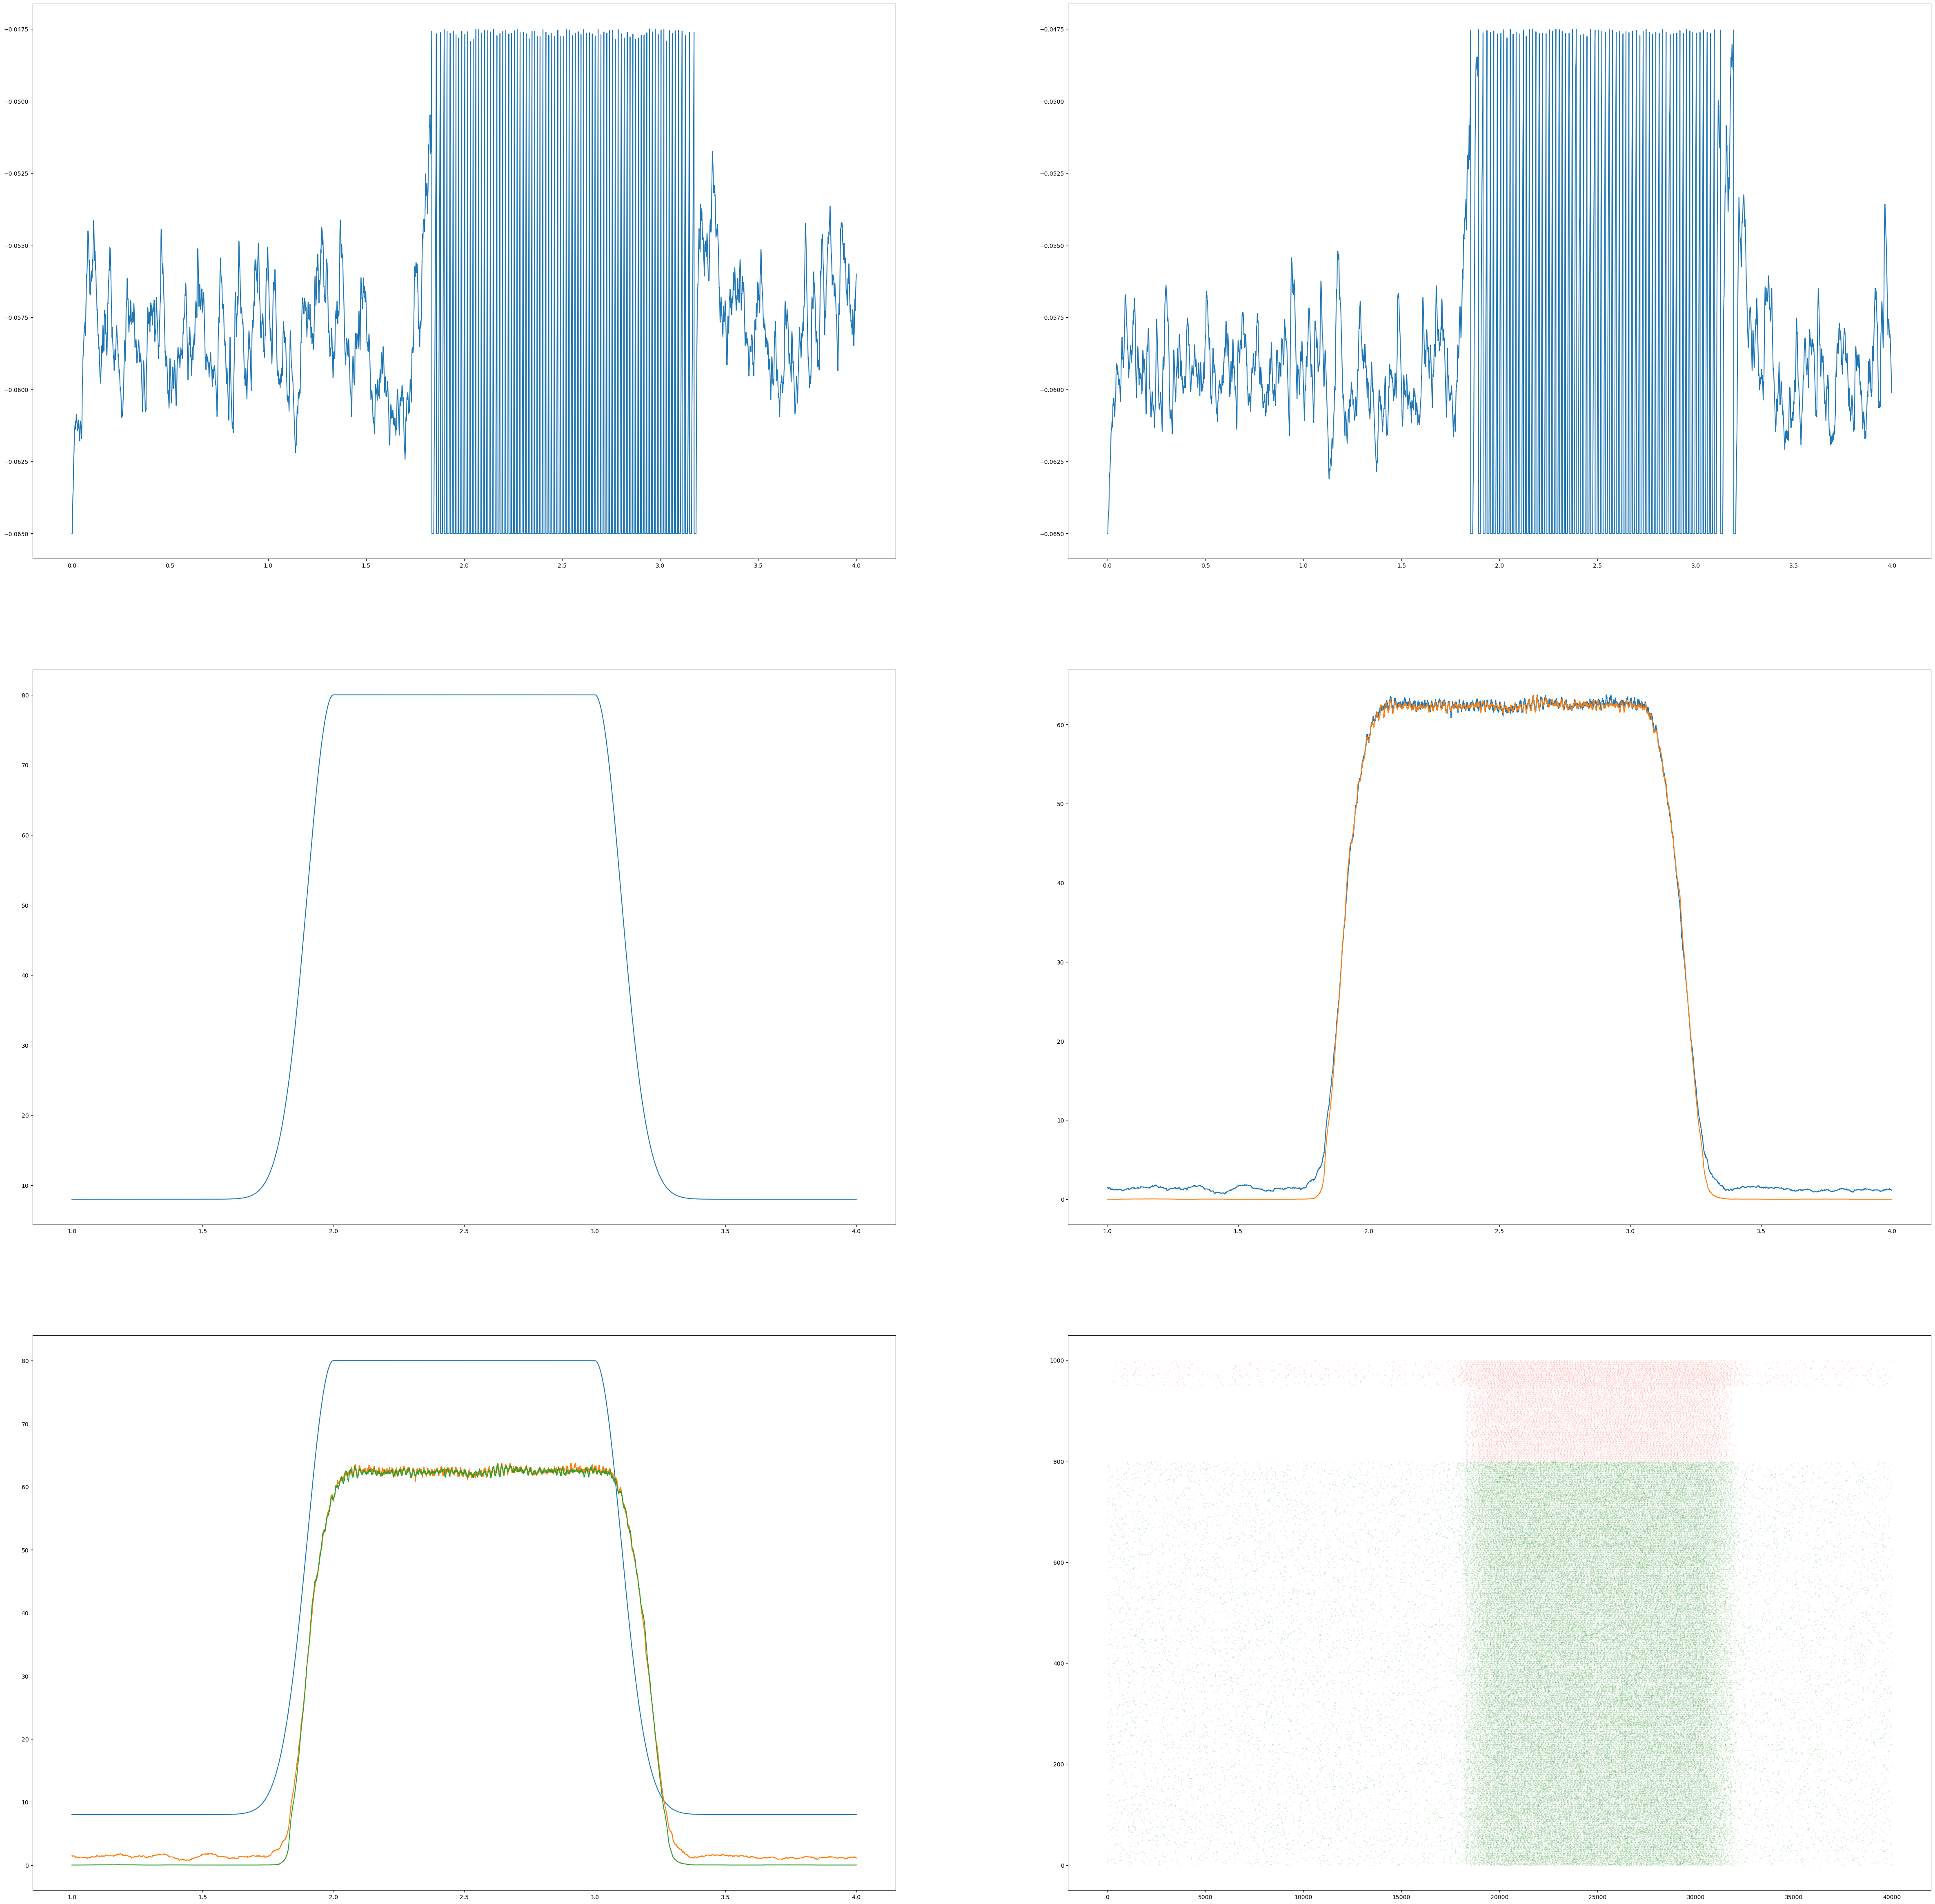

In [23]:
fig1=plt.figure(figsize=(60,60))
ax1=fig1.add_subplot(321)
ax2=fig1.add_subplot(322)
ax3=fig1.add_subplot(323)
ax4=fig1.add_subplot(324)
ax5=fig1.add_subplot(325)
ax6=fig1.add_subplot(326)

ax1.plot(time_sim, neuron1_potential_bin)
ax2.plot(time_sim, neuron2_potential_bin)

ax3.plot(time_sim[10000:40000], test_input[10000:40000])
ax4.plot(time_sim[10000:40000], fire1_result_bin[10000:40000])
ax4.plot(time_sim[10000:40000], fire2_result_bin[10000:40000])

ax5.plot(time_sim[10000:40000], test_input[10000:40000])
ax5.plot(time_sim[10000:40000], fire1_result_bin[10000:40000])
ax5.plot(time_sim[10000:40000], fire2_result_bin[10000:40000])

points_1 = np.where(fire_matrix1 > 1)
points_2 = np.where(fire_matrix2 > 1)
ax6.scatter(points_1[1], N2+points_1[0], color='red',s=0.01)
ax6.scatter(points_2[1], points_2[0], color='green',s=0.01)
# current_dir = os.path.dirname(os.path.abspath(__file__))
# output_folder = os.path.join(current_dir, 'My_AdEx_Network')
# output_path = os.path.join(output_folder, "All"+"_rest_"+str(rest)+"_AmpStim_"+str(AmpStim)+"_TauP_"+str(TauP)+"_tau_"+str(tau_S)+"_Num_"+str(Num)+".png")
# output_path='My_Union_Plot/'+"All"+"_rest_"+str(rest)+"_AmpStim_"+str(AmpStim)+"_TauP_"+str(TauP)+"_Num_"+str(Num)+".png"
output_path='My_Union_Plot/'+"All"+"_rest_"+str(rest)+"_AmpStim_"+str(AmpStim)+"_TauP_"+str(TauP)+"_tau_S_"+str(tau_S_AdEx)+"_"+str(tau_S_HH)+"_T_ref_"+str(T_ref_AdEx)+"_"+str(T_ref_HH)+"_Num_"+str(Num)+"A.png"
plt.savefig(output_path)

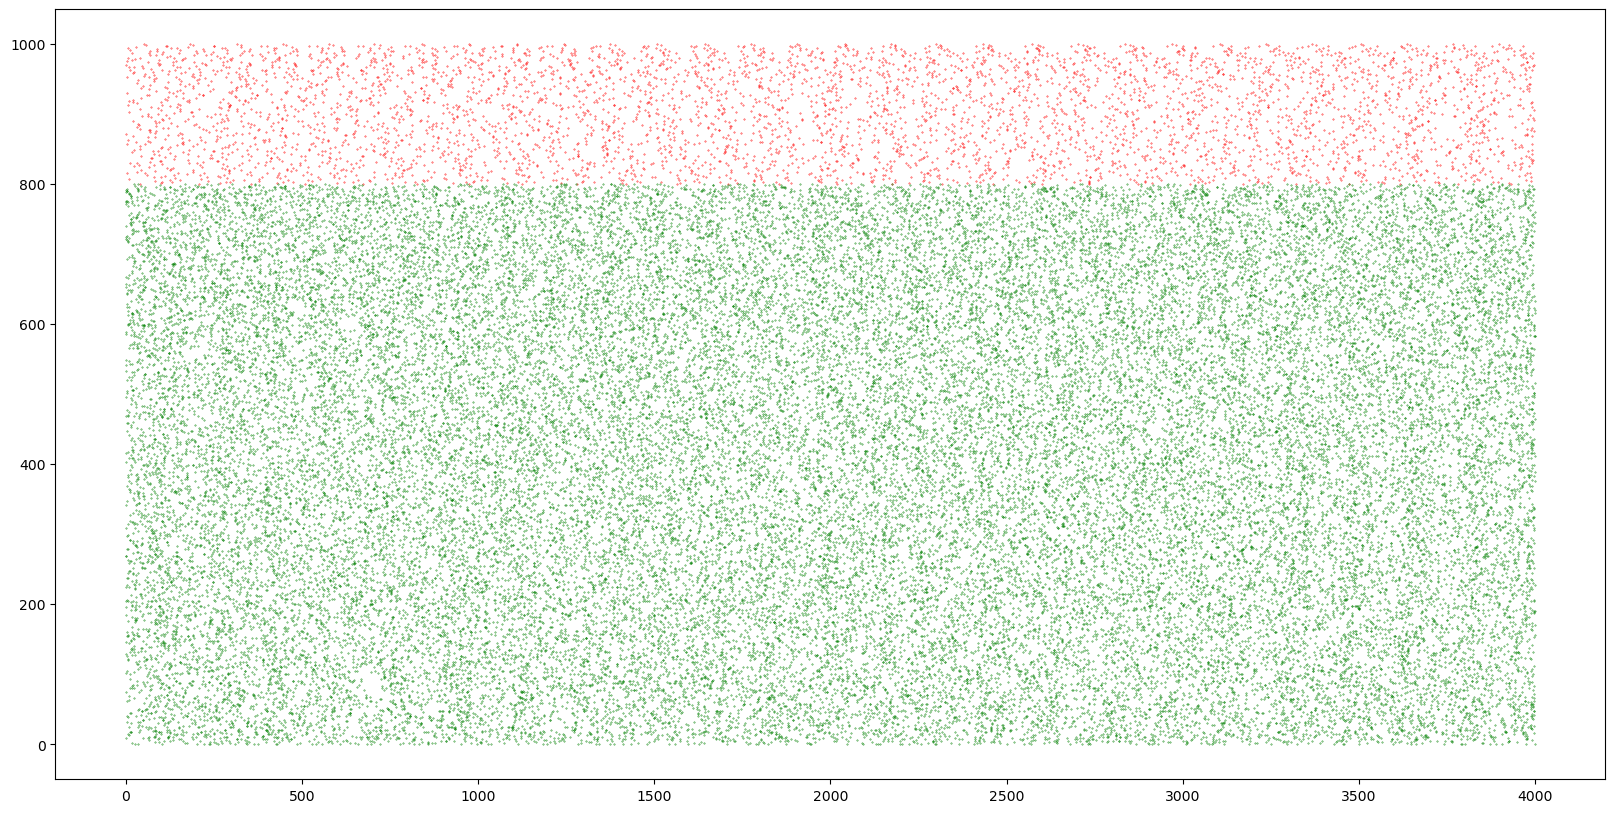

In [24]:
fig2=plt.figure(figsize=(20,10))
points_r = np.where(fire_matrix1[:,21000:25000] > 1)
points_g = np.where(fire_matrix2[:,21000:25000] > 1)
plt.scatter(points_r[1], N2+points_r[0], color='red',s=0.1)
plt.scatter(points_g[1], points_g[0], color='green',s=0.1)
output_path='My_Union_Plot/'+"Micro"+"_rest_"+str(rest)+"_AmpStim_"+str(AmpStim)+"_TauP_"+str(TauP)+"_tau_S_"+str(tau_S_AdEx)+"_"+str(tau_S_HH)+"_T_ref_"+str(T_ref_AdEx)+"_"+str(T_ref_HH)+"_Num_"+str(Num)+"A.png"
plt.savefig(output_path)